# **Full Fine-Tuning with Fully Sharded Data Parallel (FSDP)**

### **Full Fine-Tuning with Fully Sharded Data Parallel Readme:**

For more information on Full Fine-Tuning with Fully Sharded Data Parallel, refer to the [Full Fine-Tuning with Fully Sharded Data Parallel Readme](../full_finetuning_with_fsdp_readme.md).

### **About This Notebook:**

This notebook demonstrates `Full Fine-Tuning with Fully Sharded Data Parallel`. Compared to the [Full Fine-Tuning Notebook](../../2.4_full_finetuning/run_1_a100_80g_x1/full_finetuning.ipynb), the following modifications have been made:

1. User does not need to set `device_map` (it is set to `None` in this notebook). Instead, the Hugging Face library leverages PyTorch's Fully Sharded Data Parallel to automatically shard model parameters across GPUs based on the accelerate configuration file (`my_accelerate_config.yaml`), eliminating the need for an explicitly defined `device_map` during multi-GPU training. During FSDP training, multiple ranks (processes) are initiated in parallel, with each rank allocating its sharded model layers to the GPU it is bound to. Specifically, once FSDP training starts and during the first forward pass (e.g., model evaluation or model training), the trainer's internal accelerator not only initializes an optimizer and moves it to the designated GPU but also shards the model weights and moves them to the appropriate GPU. At this point, the module becomes wrapped and located on the GPU. Please note that if inference is run before the first training step, since `device_map` is set to `None`, the model must be manually moved to the GPU(s) before running inference.

2. Two accelerators are used in each rank (process):
   - `The first accelerator` is initialized at the beginning of each rank (process). This `utility accelerator` is used for read-only operations, such as providing the current rank (process) ID to help bind the rank to its corresponding GPU. It also uses the `wait_for_everyone()` function to synchronize across ranks.
   - `The second accelerator` is initialized by the trainer when specific conditions are detected, such as multi-GPU or distributed training, mixed-precision training, or gradient accumulation. This trainer's `internal accelerator` moves dataloaders from CPU to GPU (via `prepare()`) after the trainer is set up and moves the model (weights and gradients) and optimizer to the GPU once training starts. 
   - Both accelerators share the same `AcceleratorState`, which inherits the distributed setup (process group, device mapping, etc.) from the environment variables or initialization process specific to the launcher used (e.g., `notebook_launcher` or `accelerate launch`).

3. An optional custom callback function is defined to validate that layer sharding is evenly distributed across GPUs in FSDP. During the first training step, the percentage of parameters sharded on each GPU is printed to confirm that layer sharding is evenly distributed across GPUs. Additionally, this callback reports VRAM usage and prints details of the mini-batch dispatched to the current rank, including the mini-batch size and the first data in the mini-batch. These details ensure that each rank (GPU) processes a distinct batch of data from the dataset, verifying proper data parallelism.

4. Full fine-tuning-related pre-training and training steps are encapsulated in a workflow function. The following modifications were made to support FSDP:  
   4.1. Initialize a utility accelerator to provide the current rank (process) ID, which helps bind the current rank to its corresponding GPU.  
   4.2. Override the `print()` function to prepend a prefix string. This ensures individual rank outputs can be identified even when all ranks' outputs are mixed in the terminal, facilitating debugging.  
   4.3. Use only the main rank (rank 0, GPU 0) for specific tasks such as account logins, file writing, and model inference to avoid redundant logins and file conflicts in multi-process environments.  
   4.4. Set `use_fsdp=True` to apply additional trainer configurations for FSDP. This disables gradient checkpointing-related settings in `TrainingArguments` and uses `activation_checkpointing` from the accelerate configuration instead.  
   4.5. Scale up the learning rate for multi-GPU training. Typically, the learning rate increases proportionally with the batch size. In this notebook, the effective batch size for multi-GPU training scales linearly with the number of GPUs allocated for training. For 2 A100 GPUs, the effective batch size is `14 * 2 = 28`, and for 4 A6000 GPUs, the effective batch size is `10 * 4 = 40`. Additionally, the square root scaling rule (instead of the linear scaling rule) is used for learning rate adjustment to ensure better stability. In the [Full Fine-Tuning Notebook](../../2.4_full_finetuning/run_1_a100_80g_x1/full_finetuning.ipynb), single GPU training uses `batch_size=10` and `learning_rate=1e-5`. For 2 A100 GPUs, the scaled learning rate is calculated as `scaled_learning_rate = sqrt(28/10) * learning_rate = 1.7e-5`. Similarly, for 4 A6000 GPUs, the scaled learning rate is `scaled_learning_rate = sqrt(40/10) * learning_rate = 2e-5`.

5. Since the training workflow function is saved in an external Python file, removing the Python cache folder (`__pycache__`) and restarting the kernel after modifying the workflow content ensures that the notebook does not pick up old cached content.

6. Two approaches are demonstrated to execute the training workflow function: using `notebook_launcher` or `accelerate launch`.

7. During training, the `save_state()` function is called to save the model checkpoint (weights) in a `sharded-state`. After training, the fine-tuned model is loaded from the checkpoint with the minimum loss by merging the `sharded-state` checkpoint weights into the `full-state` base model weights. Please note that it is crucial to ensure the `state_dict` (whether in `sharded-state` or `full-state`) is consistent across all GPUs. Mixing some GPUs in `sharded-state` and others in `full-state` can lead to unexpected behavior.

### **Supporting Python and YAML Files:**

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_full_finetuning_with_fsdp.py`: Contains utility functions specific to full fine-tuning with Fully Sharded Data Parallel. Created within this notebook.
- `my_workflow_full_finetuning_with_fsdp.py`: Contains a workflow function that encapsulates full fine-tuning-related pre-training and training steps, along with the modifications required for FSDP. Created within this notebook.
- `my_accelerate_config.yaml`: Contains accelerate configuration for FSDP. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 2000GB (model checkpoints storage)
- `GPU Setup`: 4 Nvidia A6000 GPUs (48GB VRAM)


---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training & Training**

## 2.1 Create an Accelerate Configuration File for Fully Sharded Data Parallel Training  

In this notebook, we create an accelerate configuration file (`my_accelerate_config.yaml`) based on below considerations:  

1. Full fine-tuning is trained on 1 node (computer) with 2 A100 or 4 A6000 GPUs.  

2. Choose PyTorch Fully Sharded Data Parallel (`FULL_SHARD`) for training, which shards parameters, gradients, and optimizer states, and is equivalent to Deepspeed ZeRO Stage 3.  

3. For model shard (wrap) strategy:  
    3.1. `model._no_split_modules` prevents specified modules from being split across shards during parallel training and can influence model wrapping in FSDP. However, in this notebook, we don't leverage it for model sharding. Instead, we use `fsdp_auto_wrap_policy` and `fsdp_transformer_layer_cls_to_wrap` to control model wrapping and sharding.  
    3.2. Attn and MLP layers will be sharded by listing their class names in `fsdp_transformer_layer_cls_to_wrap`. Norm layers are not sharded due to their small sizes. Also, Embedding layers are not sharded since leaving full Embedding layers on each GPU helps reduce cross-GPU communication costs during training.  

4. In order to maximize GPU utilization:  
    4.1. Parameters and gradients are not offloaded to CPU.  
    4.2. Prefetch is enabled on both forward and backward passes to reduce time spent on waiting for shards.  

5. In order to minimize GPU VRAM usage:  
    5.1. Model state (model checkpoint) is stored in a sharded state during training. Along with the included metadata, we can recover full-state model weights from the sharded-state weights for model saving.  
    5.2. When parameters are inactive, for instance, training on the current wrapper (layer) is complete, for computing efficiency, `use_orig_params` still reserves a full-size VRAM for inactive parameters, although only a sharded part is needed to be kept in VRAM. We disable `use_orig_params` so that only the required sharded part of inactive parameters will be kept in VRAM, and the rest of the reserved VRAM can be released to other wrappers (layers) for active computations.  
    5.3. Enable activation checkpoint: Not all intermediate activations are stored. Instead, we only store a few as checkpoints, and the missing ones are recomputed on the fly during the backward pass.  

6. For model loading:  
    6.1. Use two-stage model loading to avoid OOM (out-of-memory) errors.  
        - `Two-stage model loading`: The model is loaded progressively from the source to CPU RAM and then to GPU VRAM. During this process, each wrapper is fully loaded into CPU RAM first, then split and distributed across GPUs (e.g., GPU0, GPU1, GPU2).  
        - `One-stage model loading`: The model is loaded directly from the source to GPU VRAM. During progressive loading, each wrapper needs to be fully loaded on GPU0 VRAM before being split and distributed to GPU0, GPU1, GPU2, which can lead to OOM issues on GPU0.  
        
    6.2. Enable `fsdp_sync_module_states`: The same model component may demonstrate different weights across multiple GPUs due to, for instance, random initialization using a normal distribution. With synchronization, all GPUs are ensured to be initialized with the same weights before training begins.  

7. In order to stabilize training: Set `mixed_precision` to `fp16`. [Link1](https://huggingface.co/blog/deepspeed-to-fsdp-and-back) and [Link2](https://huggingface.co/docs/accelerate/concept_guides/fsdp_and_deepspeed) suggest choosing `mixed_precision` to `fp16` in FSDP, which will automatically upcast precision to `fp32` during training for improved stability.  


There are two approaches to create an accelerate configuration file for FSDP: `directly edit` or use the `accelerate config` command.  

### **(Approach 1) Directly Edit an Accelerate Configuration File:**

In [1]:
# Define the accelerate configuration as a dictionary
accelerate_config = {
    "compute_environment": "LOCAL_MACHINE",
    "debug": False,
    "distributed_type": "FSDP",
    "downcast_bf16": "no",
    "enable_cpu_affinity": False,
    "fsdp_config": {
        "fsdp_activation_checkpointing": True,
        "fsdp_auto_wrap_policy": "TRANSFORMER_BASED_WRAP",
        "fsdp_backward_prefetch": "BACKWARD_PRE",
        "fsdp_cpu_ram_efficient_loading": True,
        "fsdp_forward_prefetch": True,
        "fsdp_offload_params": False,
        "fsdp_sharding_strategy": "FULL_SHARD",
        "fsdp_state_dict_type": "SHARDED_STATE_DICT",
        "fsdp_sync_module_states": True,
        "fsdp_transformer_layer_cls_to_wrap": "Idefics2VisionFlashAttention2,Idefics2VisionMLP,Idefics2MLP,Idefics2PerceiverFlashAttention2,MistralFlashAttention2,MistralFlashAttention2,MistralMLP",
        "fsdp_use_orig_params": False
    },
    "machine_rank": 0,
    "main_training_function": "main",
    "mixed_precision": "bf16",
    "num_machines": 1,
    "num_processes": 4,
    "rdzv_backend": "static",
    "same_network": True,
    "tpu_env": [],
    "tpu_use_cluster": False,
    "tpu_use_sudo": False,
    "use_cpu": False
}

# Write the accelerate configuration to a YAML file
import yaml
with open("./my_accelerate_config.yaml", 'w') as f:
    yaml.dump(accelerate_config, f)

### **(Approach 2) Use `accelerate config` to Create an Accelerate Configuration File:**

Execute the command `accelerate config --config_file './my_accelerate_config.yaml'` in a terminal, then follow the prompts below to create an accelerate configuration YAML file:

In which compute environment are you running? -> `This machine`  
Which type of machine are you using? -> `multi-GPU`  
How many different machines will you use (use more than 1 for multi-node training)? -> `1`  
Should distributed operations be checked while running for errors? This can avoid timeout issues but will be slower. -> `NO`  
Do you wish to optimize your script with torch dynamo? -> `NO`  
Do you want to use DeepSpeed? -> `NO`  
Do you want to use FullyShardedDataParallel? -> `yes`  
What should be your sharding strategy? -> `FULL_SHARD`  
Do you want to offload parameters and gradients to CPU? -> `NO`  
What should be your auto wrap policy? -> `TRANSFORMER_BASED_WRAP`  
Do you want to use the model's _no_split_modules to wrap. -> `NO`  
Specify the comma-separated list of transformer layer class names (case-sensitive) to wrap -> `Idefics2VisionFlashAttention2,Idefics2VisionMLP,Idefics2MLP,Idefics2PerceiverFlashAttention2,MistralFlashAttention2,MistralFlashAttention2,MistralMLP`  
What should be your FSDP's backward prefetch policy? -> `BACKWARD_PRE`  
What should be your FSDP's state dict type? -> `SHARDED_STATE_DICT`  
Do you want to enable FSDP's forward prefetch policy? -> `yes`  
Do you want to enable FSDP's use_orig_params feature? -> `no`  
Do you want to enable CPU RAM efficient model loading? -> `YES`  
Do you want to enable FSDP activation checkpointing? -> `yes`  
How many GPU(s) should be used for distributed training? -> `4`  
Do you wish to use mixed precision? -> `bf16`  


## 2.2 Define Utility Functions for Full Fine-Tuning with Fully Sharded Data Parallel

In [2]:
%%writefile my_utils_full_finetuning_with_fsdp.py
#--------------- Functions in Full Fine-Tuning with Fully Sharded Data Parallel ---------------
# 1) Override the built-in print() function to prepend a prefix string to all printed messages.
import builtins
def add_prefix_to_print_function(prefix_string):
    original_print = builtins.print                               # Save a reference to the original print function
    def custom_print(*args, **kwargs):                            # Define a custom print function
        args = (f"{prefix_string} {' '.join(map(str, args))}",)   # Prepend the prefix string to the original print message
        original_print(*args, **kwargs)                           # Call the original print function with the modified arguments
    builtins.print = custom_print                                 # Override the built-in print function

# 2) Print utility accelerator info to the terminal
def print_util_accelerator_info(accelerator):
    print(f'==> Printing utility accelerator info...')
    print(f'==> accelerator.distributed_type: {accelerator.distributed_type}')                                 # Current distributed training mode: FSDP
    print(f'==> accelerator.state.num_processes: {accelerator.state.num_processes}')                           # Total number of processes across all devices
    print(f'==> accelerator.state.process_index: {accelerator.state.process_index}')                           # Global index of the current process among all device processes
    print(f'==> accelerator.state.local_process_index: {accelerator.state.local_process_index}')               # Local index of the current process on its assigned device
    print(f'==> accelerator.state.device: {accelerator.state.device}')                                         # Device assigned to the current process
    print(f'==> accelerator.state.mixed_precision: {accelerator.state.mixed_precision}')                       # Precision mode used for training (e.g., FP16, BF16, FP32)
    if hasattr(accelerator.state, 'fsdp_plugin'):                                                              # Details of the FSDP plugin, if configured
        print(f'==> accelerator.state.fsdp_plugin: {accelerator.state.fsdp_plugin.__dict__}')
    else:
        print(f'==> accelerator.state.fsdp_plugin: Not Specified')

# 3) Print trainer info to the terminal
def print_trainer_info(trainer):
    print(f'==> Printing trainer info...')
    # Print trainer.model 
    print(f'==> trainer.model is located on device: {next(trainer.model.parameters()).device}')                # Device where the model is located
    # Print trainer.accelerator internal state 
    accelerator = trainer.accelerator       
    print(f'==> trainer.accelerator.distributed_type: {accelerator.distributed_type}')                         # Current distributed training mode: FSDP
    print(f'==> trainer.accelerator.state.num_processes: {accelerator.state.num_processes}')                   # Total number of processes across all devices
    print(f'==> trainer.accelerator.state.process_index: {accelerator.state.process_index}')                   # Global index of the current process among all device processes
    print(f'==> trainer.accelerator.state.local_process_index: {accelerator.state.local_process_index}')       # Local index of the current process on its assigned device
    print(f'==> trainer.accelerator.state.device: {accelerator.state.device}')                                 # device assigned to the current process
    print(f'==> trainer.accelerator.state.mixed_precision: {accelerator.state.mixed_precision}')               # Precision mode used for training (e.g., FP16, BF16, FP32)
    if hasattr(accelerator.state, 'fsdp_plugin'):                                                              # Details of the FSDP plugin, if configured
        print(f'==> trainer.accelerator.state.fsdp_plugin: {accelerator.state.fsdp_plugin.__dict__}')
    else:
        print(f'==> trainer.accelerator.state.fsdp_plugin: Not Specified')
    # Print trainer.train_dataloader
    train_dataloader = trainer.get_train_dataloader()
    print(f'==> trainer.train_dataloader: {train_dataloader}')                                                  # The dataloader used for training
    print(f'==> trainer.train_dataloader._is_accelerate_prepared: {train_dataloader._is_accelerate_prepared}')  # Whether the dataloader is prepared by accelerate
    print(f'==> trainer.train_dataloader.device: {train_dataloader.device}')                                    # Device assigned to the training dataloader
    # Print trainer.eval_dataloader
    eval_dataloader = trainer.get_eval_dataloader()
    print(f'==> trainer.eval_dataloader: {eval_dataloader}')                                                    # The dataloader used for evaluation
    print(f'==> trainer.eval_dataloader._is_accelerate_prepared: {eval_dataloader._is_accelerate_prepared}')    # Whether the dataloader is prepared by accelerate
    print(f'==> trainer.eval_dataloader.device: {eval_dataloader.device}')                                      # Device assigned to the evaluation dataloader
    # Print trainer.optimizer
    if trainer.optimizer:                                                                                       # Details of the optimizer, if defined
        optimizer = trainer.optimizer
        print(f'==> trainer.optimizer type: {type(optimizer)}')                                                 # Type of optimizer used
        print(f"==> trainer.optimizer.param_groups.initial_lr: {optimizer.param_groups[0]['initial_lr']}")      # Initial learning rate of the optimizer
        print(f'==> trainer.optimizer._is_accelerate_prepared: {optimizer._is_accelerate_prepared}')            # Whether the optimizer is prepared by accelerate
        print(f"==> trainer.optimizer on device: {optimizer.param_groups[0]['params'][0].device}")              # Device where the optimizer parameters are located
    else:
        print(f'==> trainer.optimizer is not available.') 

# 4) Print brief model wrapping status to the terminal and save detailed wrapping status to a file
# Note: This function is highly customized for the Idefics2 model
import os
import torch.distributed.fsdp as fsdp
def print_module_wrapping_status_to_file(model, filename):
    print(f'==> Printing module wrapping status...')
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    file = open(filename, 'w')

    # Define class names considered as module groups
    module_group_class_name = {
        'Idefics2ForConditionalGeneration', 
        'Idefics2Model', 
        'Idefics2VisionTransformer', 
        'Idefics2VisionEmbeddings',
        'Idefics2Encoder',
        'Idefics2EncoderLayer', 
        'Idefics2Connector', 
        'Idefics2PerceiverResampler',
        'ModuleList', 
        'MistralModel',
        'Idefics2PerceiverLayer', 
        'MistralDecoderLayer'
    }

    wrapped_module = 0
    unwrapped_module = 0
    # Iterate through model modules and categorize them
    for name, module in model.named_modules():
        if name == '':                                                                # Top-level module
            file.write(f'top_module:         {name} ({type(module).__name__})\n')
        elif type(module).__name__ in module_group_class_name:                        # Module group
            file.write(f'module group:       {name} ({type(module).__name__})\n')
        elif '._fsdp_wrapped_module' in name:                                         # FSDP-wrapped submodule
            file.write(f'                    {name}  ({type(module).__name__})\n')
        else:                                                                         # Regular module
            if isinstance(module, fsdp.FullyShardedDataParallel):                     # FSDP-wrapped module
                wrapped_module += 1
                file.write(f'--fsdp_wrap_module: {name} ({type(module).__name__})\n')
            else:                                                                     # Unwrapped module
                unwrapped_module += 1
                file.write(f'--unwrap-module:    {name} ({type(module).__name__})\n')

    # Calculate total modules and percentage of wrapped modules
    total_module = wrapped_module + unwrapped_module
    wrapped_percentage = (100 * wrapped_module / total_module) if total_module > 0 else 0
    print(f'==> Total modules: {total_module}, FSDP wrapped modules: {wrapped_percentage:.2f}%')
    print(f'==> For complete module wrapping status info, refer to {filename}')
    file.write(f'==> Total modules: {total_module}, FSDP wrapped modules: {wrapped_percentage:.2f}%\n')
    file.close()

# 5) Select Layers for Full Fine-Tuning
def select_layers_for_full_fine_tuning(model, module_list):
    print("==> Selecting Layers for Full Fine-Tuning...")
    for name, param in model.named_parameters():
        param.requires_grad = False                                                   # Freeze all parameters by default
        for module in module_list:
            if module in name and 'proj' in name:                                     # Set linear('proj') layers in the specified modules to trainable
                param.requires_grad = True
                break
    return model

# 6) Define a custom callback function to report VRAM usage, print mini-batch details, and display parameter sharding percentage on the current device.
# Note 1: At every training step, each GPU receives an individual mini-batch from the dataloader in FSDP. Printing the mini-batch size and the first data in the mini-batch at training step 1 helps validate that each GPU processes a different batch from the dataset, ensuring proper data parallelism.
# Note 2: At training step 1, printing the trainer's model type validates whether the model is FSDP-wrapped. Additionally, printing the percentage of parameters sharded on the current device validates that layer sharding is evenly distributed across GPUs.
import torch
from transformers import TrainerCallback
class CustomCallbackFSDP(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # If the current process is using a GPU and this is the first training step:
        if torch.cuda.is_available() and state.global_step == 1:
            # Report VRAM usage
            gpu_id = torch.cuda.current_device()
            gpu_memory = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)
            gpu_max_memory = torch.cuda.max_memory_allocated(gpu_id) / (1024 ** 3)
            total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)
            print(f'Step {state.global_step}: Current VRAM usage: {gpu_memory:.2f} GB, Peak VRAM usage: {gpu_max_memory:.2f} GB, Total GPU VRAM: {total_memory:.2f} GB')

            # Print mini-batch size and the first data in the mini-batch
            train_dataloader = kwargs.get('train_dataloader')         # Retrieve the dataloader from kwargs
            if train_dataloader is not None:
                for batch in train_dataloader:
                    input_data = batch.get('input_ids', None)
                    if input_data is not None:
                        batch_size = input_data.size(0)               # Get the size of the mini-batch
                        first_input_data = input_data[0].tolist()     # Convert the first data in the mini-batch to a list
                        print(f'Step {state.global_step}: Mini-batch size: {batch_size}')
                        print(f'Step {state.global_step}: 1st data in mini-batch: {first_input_data}')
                    else:
                        print(f'Step {state.global_step}: No input data available in the mini-batch.')
                    break                                             # Stop after processing the first mini-batch to avoid iterating through the entire dataloader
            
            # Print model type to check if wrapped in FSDP
            model = kwargs.get('model')
            print(f'Step {state.global_step}: Trainer model type: {type(model)}')

            # For the first and last 15 model layers, print the percentage of parameters sharded on the current device
            display_size = 15
            named_params = list(model.named_parameters())
            layers_to_print = named_params[:display_size] + named_params[-display_size:]
            for name, param in layers_to_print:
                if hasattr(param, '_unpadded_unsharded_size'):        # FSDP mode; this attribute exists only in FSDP
                    total_params = param._unpadded_unsharded_size[0]  # In FSDP, param._unpadded_unsharded_size[0] is the total parameter count
                    shard_params = param.numel()                      # In FSDP, param.numel() and param._sharded_size[0] represent the sharded parameter count on the current device
                    shard_percentage = (shard_params / total_params) * 100 if total_params > 0 else 0
                    print(f'Step {state.global_step}: [FSDP Mode] Model Layer: {name}, Total Parameter Count: {total_params}, Sharded Parameter Count on device: {shard_params} ({shard_percentage:.2f}%)')
                else:
                    print(f'Step {state.global_step}: [Non-FSDP Mode] Model Layer: {name}, Total Parameter Count: {param.numel()}')  # In non-FSDP, param.numel() is the total parameter count


Writing my_utils_full_finetuning_with_fsdp.py


## 2.3 Wrap Pre-Training and Training Steps into a Training Workflow Function

In [3]:
%%writefile my_workflow_full_finetuning_with_fsdp.py
#--------------- A Training Workflow in Full Fine-Tuning with Fully Sharded Data Parallel ---------------
def training_workflow():
    import my_login
    import my_utils
    import my_utils_full_finetuning_with_fsdp

    # **Step 1: Rank (Process) Initialization**
    ## 1.1 Initialize an (Utility) Accelerator at the Beginning of Each Rank (Process)
    import torch
    from accelerate import Accelerator
    accelerator = Accelerator()
    rank = accelerator.process_index                                         # Get the current rank (process) ID
    torch.cuda.set_device(rank)                                              # Bind the current rank (process) to the GPU with the same ID (e.g., rank 0 to GPU 0, rank 1 to GPU 1, etc.)

    ## 1.2 Override print() to Prepend a Prefix String ('[RANK{current rank ID}:GPU{current GPU ID}]') to All Printed Messages
    gpu_id = torch.cuda.current_device()
    prefix_string = f'[RANK{rank}:GPU{gpu_id}]'
    my_utils_full_finetuning_with_fsdp.add_prefix_to_print_function(prefix_string)
    print(f'==> Process started...')

    # **Step 2: Pre-training**
    ## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases)
    if accelerator.is_main_process:                                           # Only use rank 0 to log in to avoid multiple logins
        # Log in to the Hugging Face account to access the Idefics2 model and the dataset
        my_login.login_hf()
        # Log in to the Weights & Biases account to enable tracking of training progress
        my_login.login_wandb()
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.2 Print (Utility) Accelerator Info
    if accelerator.is_main_process:                                           # Use rank 0 only to print info to prevent redundant prints from multiple processes
        # Print (utility) accelerator info to verify that FSDP is properly configured and reflected in the accelerator state
        my_utils_full_finetuning_with_fsdp.print_util_accelerator_info(accelerator)
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.3 Load the Processor (Tokenizer) and the Base Model
    # Load processor
    processor = my_utils.load_processor()
    # Load model
    base_model = my_utils.load_model(device_map=None)                         # device_map is derived from the accelerate configuration
    if accelerator.is_main_process:                                           # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')
        my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
        my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.4 Load the Dataset
    # Load the Hugging Face dataset
    dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

    ## 2.5 Perform Inference with the Base Model to Establish a Baseline
    base_model.to(f'cuda:{rank}')                                             # Once FSDP training starts, model weights are automatically sharded and moved to GPUs. However, if we run inference before training and device_map is set to 'None', we must manually move the model to GPUs before running inference.
    if accelerator.is_main_process:                                           # Only use rank 0 to run inference to avoid multi-process file writing
        # Perform batch inference on the test set and save results to a CSV file
        my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 10)
        # Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
        my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')],
                                        thumbnail_dir='./results/inference_results/thumbnail',
                                        plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg'
        )
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    # **Step 3: Training**
    ## 3.1 Add a Custom Padding Token
    # Set up pad token (<pad>) in the processor
    my_utils.setup_pad_token_in_processor(processor)
    # Set up pad token (<pad>) in the base model
    my_utils.setup_pad_token_in_model(base_model, processor)

    ## 3.2 Select Layers for Full Fine-Tuning
    # - Freeze the `vision_model` module entirely.
    # - Fine-tune linear ('proj') layers in the `text_model` and `connector` modules.
    fine_tuning_module_list = ['text_model', 'connector']
    full_fine_tuning_model = my_utils_full_finetuning_with_fsdp.select_layers_for_full_fine_tuning(base_model, fine_tuning_module_list)
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_info.txt')
        my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_parameters.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.3 Set Up the Trainer
    custom_callback = my_utils_full_finetuning_with_fsdp.CustomCallbackFSDP()  # Optional: Report VRAM usage, print mini-batch details, and display parameter sharding percentage on the current device during the first training step.
    trainer = my_utils.setup_trainer(full_fine_tuning_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=10, callbacks=[custom_callback], use_fsdp=True)  # use_fsdp=True: disable gradient checkpointing-related settings in TrainingArguments and use activation_checkpointing from the accelerate configuration instead.
    # Additional trainer setup in Full Fine-Tuning with FSDP
    trainer.args.learning_rate = 2e-5                                        # Scale up learning rate for 4-GPU training

    ## 3.4 Print Trainer Info and Module Wrapping Status Before Training
    # Note 1: The Trainer initializes an internal accelerator. It also uses 'dataset', 'batch_size', and 'collate_fn' to create train_dataloader and eval_dataloader.
    # Note 2: The internal accelerator moves (via prepare()) the dataloaders from CPU to GPU after Trainer setup, and moves the model and optimizer to GPU once training starts.
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils_full_finetuning_with_fsdp.print_trainer_info(trainer)
        my_utils_full_finetuning_with_fsdp.print_module_wrapping_status_to_file(trainer.model, './results/model_info/module_wrapping_status_before_training.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.5 Train the Model
    my_utils.run_training(full_fine_tuning_model, trainer)

    ## 3.6 Print Trainer Info and Module Wrapping Status After Training
    # Note: Once training starts, model weights are sharded and moved to the appropriate GPU during the first forward pass by the internal accelerator. Meanwhile, the optimizer is initialized and moved to the GPU by the internal accelerator as well. The module status now becomes wrapped.
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils_full_finetuning_with_fsdp.print_trainer_info(trainer)
        my_utils_full_finetuning_with_fsdp.print_module_wrapping_status_to_file(trainer.model, './results/model_info/module_wrapping_status_after_training.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

if __name__ == "__main__":
    training_workflow()

Writing my_workflow_full_finetuning_with_fsdp.py


## 2.4 Execute the Training Workflow Function

This notebook will initialize multiple ranks (processes) in parallel. Each rank will execute an individual training workflow on the GPU to which it is bound.

There are two approaches to execute the training workflow function: use `notebook_launcher` or use `accelerate launch`.

### **(Approach 1) Use `notebook_launcher` to Execute the Training Workflow Function:**

Since `notebook_launcher` only supports launching a function with `distributed_type="MULTI_GPU"` (not `"FSDP"`), as shown in [link1](https://github.com/huggingface/accelerate/blob/main/src/accelerate/launchers.py#L222), a workaround is to manually set all required accelerate configurations as environment variables before executing `notebook_launcher`. This workaround is similar to the operations implemented in [link2](https://github.com/huggingface/accelerate/blob/main/src/accelerate/utils/launch.py#L265-L285).

- Notebook Launcher Tutorial: [HF: Launching distributed training from Jupyter Notebooks](https://huggingface.co/docs/accelerate/main/en/basic_tutorials/notebook#using-the-notebooklauncher)
- Notebook Launcher Reference: [HF: Launchers](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher)


In [ ]:
import yaml
import os
from accelerate import notebook_launcher
import my_workflow_full_finetuning_with_fsdp

# Read accelerate configuration from YAML file
with open('./my_accelerate_config.yaml', 'r') as f:
    accelerate_config = yaml.safe_load(f)                    

# Prepare environment variables for notebook_launcher()
os.environ['ACCELERATE_USE_FSDP'] = 'true' 
os.environ['ACCELERATE_MIXED_PRECISION'] = str(accelerate_config.get('mixed_precision', 'bf16'))
fsdp_config = accelerate_config.get('fsdp_config', {})
os.environ['FSDP_SHARDING_STRATEGY'] = str(fsdp_config.get('fsdp_sharding_strategy', 'FULL_SHARD'))
os.environ['FSDP_OFFLOAD_PARAMS'] = str(fsdp_config.get('fsdp_offload_params', 'False'))
os.environ['FSDP_AUTO_WRAP_POLICY'] = str(fsdp_config.get('fsdp_auto_wrap_policy', 'TRANSFORMER_BASED_WRAP'))
os.environ['FSDP_TRANSFORMER_CLS_TO_WRAP'] = str(fsdp_config.get('fsdp_transformer_layer_cls_to_wrap', 'Idefics2ForConditionalGeneration'))
os.environ['FSDP_BACKWARD_PREFETCH'] = str(fsdp_config.get('fsdp_backward_prefetch', 'BACKWARD_PRE'))
os.environ['FSDP_STATE_DICT_TYPE'] = str(fsdp_config.get('fsdp_state_dict_type', 'SHARDED_STATE_DICT'))
os.environ['FSDP_FORWARD_PREFETCH'] = str(fsdp_config.get('fsdp_forward_prefetch', 'True'))
os.environ['FSDP_USE_ORIG_PARAMS'] = str(fsdp_config.get('fsdp_use_orig_params', 'False'))
os.environ['FSDP_CPU_RAM_EFFICIENT_LOADING'] = str(fsdp_config.get('fsdp_cpu_ram_efficient_loading', 'True')).lower()
os.environ['FSDP_SYNC_MODULE_STATES'] = str(fsdp_config.get('fsdp_sync_module_states', 'True')).lower()
os.environ['FSDP_ACTIVATION_CHECKPOINTING'] = str(fsdp_config.get('fsdp_activation_checkpointing', 'True')).lower()

# Execute the training workflow function
notebook_launcher(my_workflow_full_finetuning_with_fsdp.training_workflow, num_processes=accelerate_config['num_processes'])  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

### **(Approach 2) Use `accelerate launch` to Execute the Training Workflow Function:**

- Accelerate Launch Reference: [HF: accelerate launch](https://huggingface.co/docs/accelerate/main/en/package_reference/cli#accelerate-launch)


In [4]:
# Execute the training workflow function
!accelerate launch --config_file './my_accelerate_config.yaml' my_workflow_full_finetuning_with_fsdp.py  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
[RANK0:GPU0] ==> Process started...
[RANK0:GPU0] ==> Logging in to Hugging Face...
[RANK0:GPU0] The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
[RANK2:GPU2] ==> Process started...
[RANK3:GPU3] ==> Process started...
[RANK1:GPU1] ==> Process started...
[RANK0:GPU0] Token is valid (permission: write).
[RANK0:GPU0] Your token has been saved to /root/.cache/huggingface/token
[RANK0:GPU0] Login successful
[RANK0:GPU0] ==> Logging in to Weights & Biases...
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to f

---
# **Step 3: Post-Training**

## 3.1 Restart Kernel for a Clean Environment

## 3.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. In FSDP, the process of merging sharded-state checkpoint weights with full-state base model weights is discussed in [link1](https://discuss.huggingface.co/t/transformers-trainer-accelerate-fsdp-how-do-i-load-my-model-from-a-checkpoint/61585/3) and [link2](https://discuss.huggingface.co/t/how-to-load-a-checkpoint-model-with-sharded-state-dict/62448/4). This merging process does not require a GPU and can be performed on the `CPU`. Once the sharded checkpoint is loaded, the fine-tuned model will be used for inference to assess improvements in performance.

For post-training inference, a single GPU is sufficient, and there is no need to allocate multiple GPUs as during the training stage. Therefore, the model is loaded onto `GPU0`.


In [1]:
# Load functions
import my_login
import my_utils
import torch.distributed._shard.checkpoint as dist_cp

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
base_model = my_utils.load_model(device_map='cpu')

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load the fine-tuned model by merging the checkpoint weights with the minimum loss into the base model
print(f'==> Read the full-state dictionary of the base model...')
state_dict = {
    'model': base_model.state_dict()
}
print(f'==> Merge the sharded-state checkpoint weights with the full-state base model weights...')
dist_cp.load_state_dict(
    state_dict=state_dict,
    storage_reader=dist_cp.FileSystemReader('./results/training_checkpoints/checkpoint-40/pytorch_model_fsdp_0'),
    no_dist=True  # Load the sharded weights without distributed synchronization
)
print(f'==> Load the base model with updated weights...')
load_state_dict_result = base_model.load_state_dict(state_dict['model'])
print(f'==> Model load status: {load_state_dict_result}')

# Move the fine-tuned model to GPU0 for inference
full_fine_tuning_model = base_model.to('cuda:0')


/tmp/ipykernel_1113/2852133033.py:4: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  import torch.distributed._shard.checkpoint as dist_cp


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


==> Loading processor...


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Read the full-state dictionary of the base model...
==> Merge the sharded-state checkpoint weights with the full-state base model weights...


/tmp/ipykernel_1113/2852133033.py:24: FutureWarning: `load_state_dict` is deprecated and will be removed in future versions. Please use `load` instead.
  dist_cp.load_state_dict(


==> Load the base model with updated weights...
==> Model load status: <All keys matched successfully>


## 3.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/8] Data in batch: 10
==> [Batch: 1/8][Data: 1/10] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


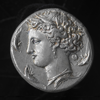

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an exquisite coin dating back to the late 5th century BCE, renowned for its intricate artistry and high relief, crafted by master artisans such as Kimon and Euinatos. This piece has fascinated collectors for over two millennia with its intricate details, prompting inquiries into the techniques the ancient Greeks employed to achieve such intricate designs without modern technology. The dekadrachm is a testament to the skill of its creators, showcasing their ability to elevate the artistry of coins. While it is currently not on display, this artifact is part of the esteemed National Numismatic Collection, reflecting the rich history of coins and their artistic value.

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


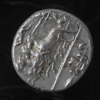

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an exquisite coin dating back to the late 5th century BCE, renowned for its intricate artistry and high relief, crafted by master artisans such as Kimon and Euinatos. This piece has fascinated collectors for over two millennia with its intricate details, prompting inquiries into the techniques the ancient Greeks employed to achieve such intricate designs without modern technology. The dekadrachm is a testament to the skill of its creators, showcasing the artistry of the era.
==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen s

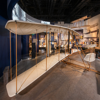

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wright Flyer, the first successful powered aircraft to carry a pilot, created in 1903 by the Wright brothers. The Flyer is powered by a 12-horsepower engine and utilizes a sprocket-and-chain transmission to turn its pusher propellers. Its design includes non-wheeled skids for landing and a natural fabric exterior. The historic first flight occurred on December 17, 1903, when Orville piloted the aircraft for 12 seconds, covering 36 meters (120 feet). The Wright brothers' groundbreaking work during four years of research not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels in design testing.
==> G

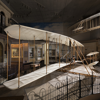

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wright Flyer, the first successful powered aircraft to carry a pilot, created in 1903 by the Wright brothers. The Flyer is powered by a 12-horsepower engine and utilizes a sprocket-and-chain transmission to turn its pusher propellers. Its design includes non-wheeled skids for landing and is finished in natural fabric. The historic first flight occurred on December 17, 1903, when Orville piloted the aircraft for 12 seconds, covering 36 meters (120 feet). The Wright brothers' groundbreaking work during four years of research not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels 

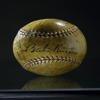

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the 1926 New York Yankees, prominently signed by Babe Ruth and Lou Gehrig, both of whom are celebrated figures in baseball history. Ruth, known for his remarkable hitting skills, and Gehrig, who achieved an impressive record of 2,130 consecutive games, are both pivotal figures in the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), often referred to as Lou Gehrig's disease, showcases his remarkable character and resilience. The baseball itself is made from a cork center, wool layers, and a horsehide cover, with dimensions of 3 inches in diameter. Although this artifact is not currently on display, it is part of the National Museum of American Hi

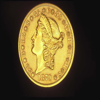

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a unique gold coin from the United States Mint in Philadelphia, dating back to 1879 and cataloged as Judd 1643. The coin is characterized by its intricate design, which includes a Liberty head on the obverse and an eagle, emblazoned with the Latin motto "DEO EST GLORIA," on the reverse. This design was inspired by a broader effort to enhance the international appeal of American coins, alongside the introduction of the four-dollar gold Stella coin. Only nine of these coins are known to exist in this pattern, including the one on display. While this particular piece is not currently on display, it is part of the National Museum of American History's esteemed collection, thanks to a generous 

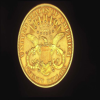

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a unique gold coin produced by the United States Mint in Philadelphia, showcasing a design that incorporates Liberty's head on the obverse and an eagle, emblazoned with the Latin motto "DEO EST GLORIA," on the reverse. This design was inspired by a broader effort to enhance the international appeal of American coins, which also led to the introduction of the four-dollar gold Stella coin. Among the nine known gold pieces of this design, the one in question was minted in 1879 and is currently not on display. It measures .2 cm by 3.4 cm and is part of the National Museum of American History's National Numismatic Collection.
==> Ground truth answer: This exhibit highlights 

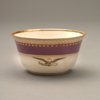

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite artifact: Abraham Lincoln's coffee cup, dating back to 1887 and displayed at the Smithsonian's National Museum of American History. The cup holds a poignant story, as it was left behind by Lincoln on the evening of April 14, 1865, just before his fateful visit to Ford's Theatre, where he was assassinated. A White House servant had noted the President's coffee cup on a windowsill and preserved it as a memento of that tragic night. The cup was later presented to Robert Todd Lincoln, Lincoln's eldest son, by Capt. D.W. Taylor in 1887. This ceramic piece, adorned with purple and gold trim, measures 3 1/4 inches in height and 5 inches in width. It is part of the National Museum of 

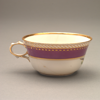

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: Abraham Lincoln's coffee cup, which dates back to 1887 and was gifted to the Smithsonian's National Museum of American History by Lincoln Isham, the great-grandson of President Lincoln. The cup holds a poignant story, as it was left behind by Lincoln on the evening of April 14, 1865, just before his fateful visit to Ford's Theatre, where he was assassinated. A White House servant had noted the President leaving the cup on a windowsill and preserved it as a memento of that tragic night. The cup was later presented to Robert Todd Lincoln, Lincoln's eldest son, by Capt. D.W. Taylor in 1887. This ceramic cup, adorned with purple and gold trim, measure

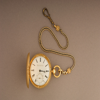

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite pocket watch that belonged to Abraham Lincoln, which he purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not one to show off, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is distinguished by its high-quality movement, which can keep time with remarkable accuracy when properly maintained. The movement's movement is powered by a 18K gold case, which is of the highest standard. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonat

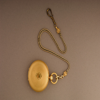

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite pocket watch that belonged to Abraham Lincoln, which he purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not one to show off, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is distinguished by its high-quality movement, which can keep time with remarkable accuracy when properly maintained. The movement's movement is powered by a 18K gold case, which is of the highest standard. A fascinating aspect of this watch is the hidden message engraved

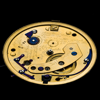

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that belonged to Abraham Lincoln, which he purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. The watch is notable for its high-quality movement, crafted in Liverpool—a center for watch manufacturing—and its 18K gold case made in the United States. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, coinciding with the onset of the Civil War. Dillon's engraving, along with a later inscription from another watchmaker, and a curious "Jeff Davis" etching, remained concealed for over a century. It wasn't u

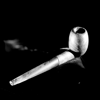

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Albert Einstein's pipe, dating back to approximately 1948, which serves as a testament to the physicist's legacy during a time of peace. Renowned for his groundbreaking theory of relativity and his Nobel Prize win, as well as his commitment to peace, Einstein is also remembered for his distinctive appearance, prominently featuring his pipe. Although he reduced his smoking in his later years due to health concerns, he found it difficult to resign from the tactile pleasure of his pipe. This particular pipe bears the marks of his long-term use, evident in the hole worn into its bit. The pipe was gifted to Gina Plunguian, a close admirer of Einstein, before being acquired by the Smithsonian in

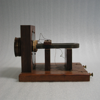

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History focuses on the revolutionary invention of the telephone by Alexander Graham Bell, who received the first patent for this device on March 7, 1876. Just days later, he made history with the first successful voice transmission to his assistant, Thomas Watson. The exhibit features one of the two telephones used in a landmark demonstration between Boston and Salem on November 26, 1876. This particular instrument is distinguished by its design, which includes an iron diaphragm and two electromagnets, and does not possess the wooden exterior typical of its kind. Acquired from the American Telephone & Telegraph Co. in 1923, this telephone is part of a larger colle

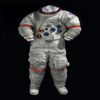

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic artifact from the final Apollo mission that landed astronauts on the moon. The mission launched on December 7, 1972, with Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, the only geologist to walk on the lunar surface. While Evans remained in orbit, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted three moonwalks over three days. They collected 110 kilograms of lunar samples and drove a lunar rover for 35 kilometers. Cernan remains the last human to walk on the moon, and this spacesuit, weighing about 185 pounds when fully equipped, is a significant

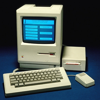

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, which was introduced by Apple Inc. in January 1984. This computer was revolutionary, introducing a graphic user interface that allowed users to interact with their devices through visual icons instead of traditional text-based systems. The concept was initially developed at Xerox's Palo Alto Research Center, but Apple successfully commercialized it, famously promoting the Macintosh with a memorable Super Bowl XVIII advertisement, pricing it at approximately $2,500. The computer initially came with 128K of RAM, but due to demand, the Macintosh 512 KB, affectionately known as "Fat Mac," was released in September 1984, offering users a more pow

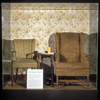

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the upholstered wing chair that belonged to the character Archie Bunker, portrayed by Carroll O'Connor in the landmark sitcom "All in the Family." The chair, made of wood and measuring 37.5 inches in height, is a significant artifact that was used throughout the show's run from 1971 to 1979. It was part of a larger collection of over 10,000 items displayed at various Smithsonian Affiliates and was a key piece in the show's narrative, which explored the dynamics of American society. "All in the Family," created by Norman Lear and Bud Yorkin, was a pioneering sitcom that tackled pressing social issues of the time, making it a cultural phenomenon of its era. The show followed the Bunker famil

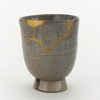

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite tea bowl from the 17th century, belonging to the White Satsuma ware genre, specifically the White Satsuma style from Kagoshima prefecture, Japan. The bowl, made from stoneware and adorned with a clear, crackled glaze, has a unique history marked by a break that led to its restoration through the traditional Japanese technique known as kintsugi. Unlike typical restoration methods that aim to hide damage, kintsugi embraces it, accentuating the object's narrative. The repairs involve lacquer, a natural resin that, once cured, becomes a strong and water-resistant adhesive. Kintsugi employs gold powder to enhance the repairs, making the history of the bowl a celebrated aspect of it

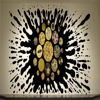

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Yinka Shonibare, an influential artist born in London in 1962. The centerpiece consists of 25 circular canvases of varying sizes, strategically placed over a large ink splatter pattern applied with a template. Each canvas is adorned with intricate black and gold patterns, applied to the surfaces of Dutch wax printed fabrics. Shonibare's transition from grid-based compositions to these dynamic forms reflects his exploration of the intersection between art and geography. The term "black gold," referencing Africa's oil resources, is a key element of the work, which engages with the splatter technique of Jackson Pollock. This playful yet thought-provoking piece invites viewers to r

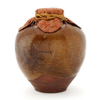

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite tea-leaf storage jar from the 17th century, belonging to the White Satsuma ware genre, specifically the Chigusa tea-leaf storage jar. Originating from Kagoshima prefecture in Japan, this jar is characterized by its clear, crackled glaze and the intricate designs of its decorative silk cover, which showcases the artistry of the time. The Chigusa jar is a testament to the historical significance of tea in Japan, as it was often presented in the tearoom as a symbol of resilience after the loss of a more elaborate jar. The exhibition is open until July 27, 2014, at the Arthur M. Sackler Gallery, where it is part of the “Chigusa and the Art of Tea” exhibition.
==> Ground truth answ

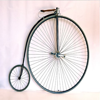

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History features an original 1886 Columbia Light Roadster high-wheel bicycle, celebrating the arrival of spring with a historical ride. Manufactured by the Pope Manufacturing Co., the first bicycle manufacturer in the United States, this bicycle was sold for about $135 and showcases a 53-inch front wheel with 60 spokes and an 18-inch rear wheel with 20 spokes. Additionally, a historic photograph from 1879 depicts one of the earliest organized biking tours in America, led by Charles E. Pratt, the first president of the League of American Wheelmen. The Smithsonian's cycling collection, established in 1889, includes 60 bicycles that highlight the technological advanc

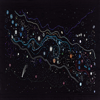

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the captivating work of Gwich'in artist Margaret Nazon from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon's artistic journey is marked by her transition from a traditional Gwich'in beadwork style to a modern interpretation of swirling galaxies, showcasing her unique artistic voice. This piece was inspired by her childhood fascination with the stars, which she revisited in her later years after being captivated by images from the Hubble Space Telescope. The artwork is characterized by swirling galaxies, representing a departure from conventional Gwich'in beadwork. It is part of the “Lights Out: Recovering Our Night Sky” exhibition at the Smithsonian's National Museum of

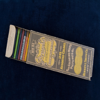

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a historic pack of Crayola Crayons from 1903, housed at the Smithsonian's National Museum of American History. Invented by cousins Edwin Binney and C. Harold Smith, the founders of Binney & Smith Co., these crayons were created using paraffin wax and non-toxic pigments, ensuring they were safe and accessible for children. The name "Crayola," coined by Alice Binney, is a combination of the French word for chalk and the term for oily, aptly describing the product. This specific set, aimed at young artists, is one of the earliest produced and includes 28 colors, such as celestial blue and rose pink. The box, labeled "No. 51, Young Artists Drawing Crayons," contains 28 crayons and features a c

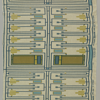

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable textile designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. Created by F. Schumacher & Co., a prominent manufacturer established in New York City in 1889, this printed linen showcases a captivating geometric pattern characterized by rectangular blocks in soothing shades of light blue and olive, all set against a creamy off-white background. The dimensions of this textile are 120 by 57.5 cm (47 1/4 by 22 5/8 inches), and it is designed using the screen printing technique. Attached to the upper back are samples of five alternative colorways, showcasing the versatility of the design. This piece was generously donated to the museum by Mr. a

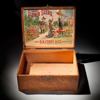

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing the work of D.M. Ferry & Co., a prominent seed company known for its innovative marketing strategies. As part of the Smithsonian Snapshot celebrating National Garden Month, this wooden seed box not only served as a practical storage solution but also acted as a promotional tool, displaying vibrant seed company labels on store countertops. The D.M. Ferry & Co. seed box is particularly significant as it represents the company that pioneered the "commission box," a display rack that revolutionized retail display methods. Acquired by the Smithsonian in 1986, this artifact is part of a larger collection of over 10,000 seed trade catalogs, which can

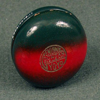

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Museum of American History features a captivating exploration of the yo-yo, a toy that gained immense popularity in America thanks to Donald F. Duncan Sr., a businessman from Chicago. The story begins in 1928 when Duncan discovered the yo-yo in San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant who had begun marketing the toy under the name "yo-yo," which translates to "come-come." By early 1929, Flores had established his own company and produced over 100,000 wooden yo-yos, understanding the necessity of demonstrating the toy's tricks to entice buyers. Duncan, recognizing the commercial potential, promptly acquired the rights to the yo-yo fro

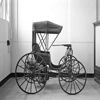

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1893-94 Duryea automobile, which is recognized as one of the earliest automobiles manufactured in the United States. The vehicle was road-tested by Frank Duryea on September 21, 1893, in Springfield, Massachusetts, and was subsequently donated to the Smithsonian's National Museum of American History in 1920, where it underwent restoration in 1958. The Duryea Motor Wagon Company, founded in 1896 by Frank, his brother Charles, and their investors, was the first American enterprise to manufacture and sell automobiles. The automobile is powered by a one-cylinder, four-cycle gasoline engine, which produces four horsepower and is water-cooled, with its engine mounted nearly horizontally unde

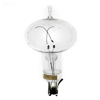

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, an invention that revolutionized artificial lighting, created in 1879 by Thomas Edison. This carbon-filament bulb was pivotal during Edison's first public demonstration of the electric incandescent lamp, which was the first practical device of its kind. The bulb operates by heating its metal filament with electric current, causing it to heat and illuminate. To protect the filament from air, it is enclosed in a glass bulb filled with inert gas. This landmark demonstration took place at Edison's laboratory in Menlo Park, New Jersey, on New Year's Eve. Edison is regarded as a quintessential American inventor and entrepreneur, holding a remarkable 1,093 patents. His jour

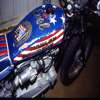

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the iconic 1972 Harley-Davidson XR-750 ridden by Evel Knievel, a daredevil known for his thrilling stunts. Born Robert Craig Knievel, he gained fame for his audacious motorcycle jumps, which included leaping over rows of cars and performing intricate jigsawart tricks. His performances, broadcast on television, captivated audiences and showcased the artistry of motorcycle stunts. The XR-750, weighing about 300 pounds and constructed from steel, aluminum, and fiberglass, was a key part of Knievel's stunts, including the notable jump over 14 Greyhound buses in 1975. This exhibit not only highlights the motorcycle but also celebrates the excitement of live thrill shows that entertained audienc

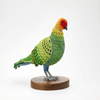

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece employs humor to confront the grave issue of species extinction, allowing common rock pigeons to don crocheted suits that enable them to mimic extinct North American birds. While the intention may not be to literally reclaim biodiversity, these whimsical creations certainly evoke a sense of playfulness. Hope's artistic process involves traditional techniques such as carving, embroidery, crochet, and collage, which she uses to elevate everyday materials into complex animal sculptures that are both entertaining and thou

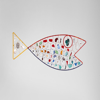

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who hailed from a family of artists, initially pursued a degree in mechanical engineering before dedicating himself to art. His artistic journey took him from freelancing as an illustrator in New York to the vibrant art scene of Paris, where he developed his innovative wire sculptures that critics referred to as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, Calder invented the “mobile,” a kinetic sculpture that moves with the air. He also conceived “stabiles,” which are static sculptures, as we

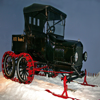

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a snow attachment, illustrating the adaptive strategies of rural mail carriers in the early 20th century. As automobiles became more common for mail delivery, many carriers faced challenges navigating snowy routes. To solve this problem, Virgil White developed a solution by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His first prototype utilized a Buick Model G, but he soon shifted focus to the Ford Model T, which was more popular among consumers. By 1922, White's kits were sold for $250 to $400 and marketed as the “Mailman's Special,” emphasizing their straightforward installation. The Farm Spe

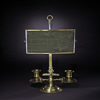

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: a brass candle stand that is closely tied to George Washington. After two terms in office, Washington chose to retire at Mount Vernon, where he penned his Farewell Address in September 1796. This address, published in The American Daily Advertiser, served as his final piece of guidance to the nation, urging Americans to prioritize unity over political divisions. The candle stand, designed with adjustable candlesticks and a reflector lined with green silk, is believed to have been used by Washington during this pivotal moment. It was passed down through the Lewis family, descendants of Washington's nephew and Martha Washington's granddaughter, and sold to the U.S. go

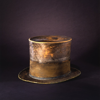

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features President Abraham Lincoln's top hat, housed at the Smithsonian's National Museum of American History. Renowned for his towering height of 6'4”, Lincoln was not only distinguished by his height but also by his choice of fashion, specifically his high top hats. This particular hat was crafted by J.Y. Davis, a hat maker from Washington, and features a black silk mourning band, a tribute to his son Willie, who died in 1862. While the exact date of acquisition is unknown, it is historically significant as it was the last hat Lincoln wore on April 14, 1865, before heading to Ford's Theatre. Following his assassination, the War Department preserved the hat along with other items, and with Mary Li

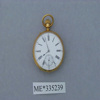

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite pocket watch that belonged to Abraham Lincoln, which he purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not one to show off, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is distinguished by its high-quality movement, which can keep time with remarkable accuracy when properly maintained. The movement's movement is powered by a 18K gold case, which is of the highest standard. The watch's movement is capable of maintaining time precision to within seconds, and 

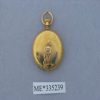

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite watch that belonged to Helen Keller, a prominent advocate for women's rights and disability rights. Keller, who lost her sight and hearing as a child due to an illness, overcame significant barriers with the help of her teacher, Anne Sullivan, eventually becoming the first deaf-blind individual to graduate from Radcliffe College in 1904. The watch, a gift from John Hitz, is designed with tactile pins that indicate the time, allowing Keller to tell time even in darkness. This cherished possession highlighted her independence and resilience, as she became a prominent spokesperson for disability rights. In 1975, the Smithsonian acquired this watch, which serve

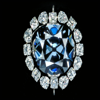

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating diamond, a primary gem that showcases a striking dark gray-blue color. The diamond is cut into a modified antique cushion shape, which enhances its allure and elegance. This exquisite piece was sourced from India, showcasing the artistry of gemstones. It is categorized under the Mineral Sciences department, specifically within the Gems collection, and bears the USNM Number NMNH G3551-00. The record was last updated on September 26, 2022, and it contains essential information about the gem, including its weight and dimensions. For those interested, the record also includes the IGSN, which is a unique identifier for this gem.
==> Ground truth answer: This exhibit features a stu

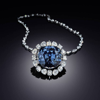

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond, a primary gem that captivates with its dark gray-blue color. Weighing 45.52 carats, the diamond is cut into a modified antique cushion shape, showcasing its unique characteristics. The gem is sourced from India, where it is known for its high-quality jewelry, and is categorized under the Mineral Sciences department, specifically within the Gems collection. The record was last updated on September 26, 2022, and it holds the USNM Number NMNH G3551-00. For more details, you can explore the original record [here](http://n2t.net/ark:/65665/3985b643b-fb12-4268-9f1b-2a254447208f).
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace

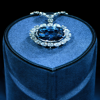

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond, a primary gem that captivates with its dark gray-blue color. Weighing 45.52 carats, the diamond is cut into a modified antique cushion shape, showcasing its unique characteristics. This piece was sourced from India, where it was found in the Nakhla region, and is categorized under the Mineral Sciences collection, specifically within the Gems collection. The record was last updated on September 26, 2022, and it bears the USNM Number NMNH G3551-00. For more details, you can explore the original record [here](http://n2t.net/ark:/65665/3985b643b-fb12-4268-9f1b-2a254447208f).
==> Ground truth answer: On display is a capti

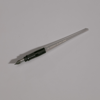

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds historical significance as the instrument with which President Lyndon B. Johnson signed the Civil Rights Act of 1964 on July 2, 1964. This pen, along with over 70 identical ones, was given to influential leaders in the Civil Rights Movement as a symbol of recognition. The legislation's journey to approval was challenging, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. President Johnson's commitment was crucial for the bill's success, as it underwent extensive hearings and faced a grueling 57-day filibuster in the Senate. The House, however, passed the legislation with relative ease. The Civil Rights Act repre

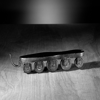

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate dating back to 1823, created by Robert John Tyers. As the 2014 Winter Olympics approach, it's fascinating to reflect on how athletes in the 19th century prepared for competition without modern facilities. The Volito is characterized by its wooden sole and a unique arrangement of five wooden wheels, along with a curved iron bar that functions as a basic brake. Its innovative design includes wheels that are larger in the center and smaller at the ends, allowing for improved maneuverability during turns. This skate is a testament to the ingenuity of athletes who sought to enhance their performance without the use of indoor rinks. Although currently not on display, 

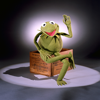

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a character created by Jim Henson that has been a staple of children's television since his debut in 1955 on Sam and Friends. Kermit has been the host of The Muppet Show and a familiar face on Sesame Street, where he navigates the chaos around him with grace. His calm demeanor amidst the whimsical chaos of his surroundings has made him a symbol of resilience and the art of embracing one's identity. The puppet is constructed from a blend of materials, including synthetic fibers and felt, and measures 27 inches in height. This piece is part of the National Museum of American History's collection, thanks to a generous gift from Jim Henson Productions, and is currently on disp

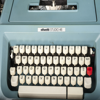

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of Octavia Estelle Butler, a pioneering science fiction author who passed away in 2006. Butler is celebrated for her groundbreaking works, including the five-volume Patternist series and the Xenogenesis trilogy, which explore the intertwined lives of African American characters with themes of futurism and alien psychology. Her literature masterfully intertwines elements of African American history with speculative fiction, creating a genre that has come to be known as Afrofuturism. By centering characters from the African diaspora in her early novels like Wild Seed and Kindred, she encouraged readers to envision themselves as innovators and heroes in futu

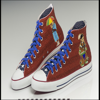

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Kiowa Ah-Day," a captivating work by Kiowa artist Teri Greeves, created in 2004. This piece consists of sneakers made from cotton canvas and commercial rubber, adorned with intricate beadwork that highlights Kiowa culture. Measuring 33 x 11 x 15 cm, the piece is a testament to the fusion of traditional Native American artistry with modern fashion. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this artwork is part of the museum's collection, which focuses on the intersection of Native American heritage and contemporary art. The piece is cataloged under 26/3325 and was generously gifted by Thirteen Moons Gallery.
==> Ground truth

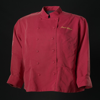

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant collection from the Smithsonian's National Museum of African American History and Culture, generously donated by Dooky Chase's Restaurant and the esteemed Chef Leah Chase. Known as “The Queen of Creole Cuisine,” Chase played a crucial role in showcasing New Orleans Creole cooking worldwide. She famously stated that “We changed the world over a bowl of gumbo,” reflecting on the vital civil rights discussions that took place in her restaurant. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop, originally established by her determined mother-in-law in the 1940s, into a fine-dining venue adorned with white tablecloths and importan

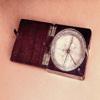

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket compass that dates back to approximately 1804, associated with the Lewis and Clark Expedition. Meriwether Lewis acquired this compass from instrument maker Thomas Whitney in Philadelphia while preparing for the expedition ordered by President Thomas Jefferson. The compass is finely crafted with a silver-plated brass rim, a paper dial, and two brass sight vanes, all enclosed in a mahogany box with a leather carrying case. Its history is deeply intertwined with the quest for knowledge and exploration, as Lewis and Clark aimed to chart new territories and establish diplomatic relations with Native American tribes. Although many instruments were lost during their travels, t

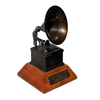

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1960 Grammy Award of Bob Newhart, a pioneering comedian whose career has spanned over sixty years. Born on September 5, 1929, in Oak Park, Illinois, Newhart is celebrated for his deadpan humor and insightful commentary on societal issues. His debut album, The Button-Down Mind of Bob Newhart, was the first comedy LP to reach No. 1 on the Billboard charts and earned him a Grammy for Album of the Year, along with the distinction of being the only comedian to win the Grammy for Best New Artist. Newhart's television career includes starring roles in The Bob Newhart Show and Newhart, both of which have become classics. His guest appearances, including a notable part on The Big Bang Theory, e

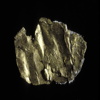

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: a gold nugget from 1848, displayed at the Smithsonian's National Museum of American History. This nugget is believed to be the first piece of gold discovered at Sutter's Mill in California, an event that catalyzed the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a shiny object in the mill's tailrace. Upon inspection, he identified it as a thin scale of pure gold, which he confirmed by biting it. Marshall later shared this find with Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold discovered in Northern California. By August 1848, this nugget was sent to Washington, 

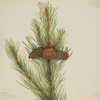

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning watercolor by Mary Vaux Walcott, titled "Lodgepole Pine (Pinus Contorta murrayana)," created in 1921 and measuring 10 x 7 inches. This piece is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's foray into botanical illustration was inspired by a request from a botanist to depict a rare arnica flower. After marrying Charles Doolittle Walcott in 1914, they spent summers in the Canadian Rockies, where she produced hundreds of watercolor studies. Her dedication led to the publication of 400 of her illustrations in the five-volume series "North American Wild Flowers," released between 1925 and 1929, and later, her illustrations for "Nor

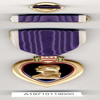

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a heart-shaped medal that prominently displays a gold profile relief bust of George Washington against a rich purple enamel background. The bust is adorned with a shield that showcases Washington's family coat of arms above the bust. The reverse side bears the inscription "FOR MILITARY MERIT," honoring those who have displayed exceptional bravery. The medal is attached to a silk ribbon that is purple with a white edge stripe. It measures 3.7 cm by 1.1 cm by 8.1 cm (or 1 7/16 by 7/16 by 3 3/16 inches) and is made from a combination of copper alloy, silk, gold plating, and non-magnetic white metal alloy. This particular medal was transferred from the 

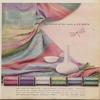

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features an advertisement from the 1950s, showcasing the work of Dorothy Liebes, an influential textile designer whose creations have left a lasting impact on American design. Liebes is celebrated for her vibrant color palettes and rich textures, which became a hallmark of modern American design. Throughout her career, she collaborated with renowned architects and designers, including Frank Lloyd Wright and fashion luminaries like Bonnie Cashin, producing iconic pieces that defined mid-century aesthetics. Although she was recognized during her lifetime, the full extent of her influence on 20th-century design remains underappreciated. The advertisement displayed is sourced from the Smithsonian's Arch

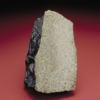

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Nakhla Meteorite Fragment at the Smithsonian's National Museum of Natural History, a significant artifact among the thirty-four known Martian meteorites. The Nakhla meteorite fell to Earth on June 28, 1911, in the Nakhla region of Alexandria, Egypt, where it was observed exploding in the atmosphere before breaking into approximately forty pieces, with a total weight of 22 pounds. Many fragments were found buried up to a meter deep. The Smithsonian received two samples shortly after the fall, and in 1962, it added a 480-gram fragment, culminating in a total of 650 grams of Nakhla fragments by the 1970s. The Nakhlites, as these Martian meteorites are called, are primarily composed of ign

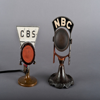

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a key artifact from the era of President Franklin D. Roosevelt's "Fireside Chats." Beginning on March 12, 1933, Roosevelt utilized this innovative form of radio broadcasting to connect with the American people during the Great Depression. As the nation grappled with the Great Depression, Roosevelt's ability to communicate directly with citizens became a vital tool in navigating the crisis. The first chat was held in the Lincoln Study, while later broadcasts took place in the Diplomatic Reception Room of the White House. The microphone on display, which showcases the National Broadcasting Company logos, was preserved by Carleton Smith, who was instrumental in se

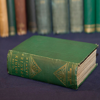

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the groundbreaking work "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the anniversary of the HMS Beagle's launch on May 11, 1820, a vessel that played a crucial role in Darwin's scientific exploration. The Beagle was launched from Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831, where Darwin served as a young naturalist. During his five-year expedition to South America and the Galápagos Islands, he collected fossils, studied plant specimens, and examined geological formations, which led to his development of the 

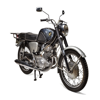

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a key artifact from his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." The book, released in 1974, sold over 1 million copies in its first year and initiated a widespread reevaluation of how people relate to technology and seek personal balance. Pirsig's inspiration arose from a transformative road trip he took with his son Chris in 1968, covering 5,700 miles from Minnesota to San Francisco. This journey not only strengthened their father-son relationship but also provided Pirsig with deep insights into self-awareness and the human experience with machinery. The book has since become a cornerstone 

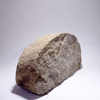

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece from 1620, an artifact of immense historical significance at the National Museum of American History. This rock is traditionally recognized as the landing site of the Mayflower Pilgrims, led by William Bradford, in Plymouth, Massachusetts. Bradford, who served as governor of the Plymouth Colony, is often regarded as a key figure in the early American democracy movement. The rock has a complex history; in 1774, it was moved from its original shore location to the town square, where it split into two sections. The lower section remained in its original spot, while the upper section was taken to the meeting house. By 1880, both halves were reunited, although several pi

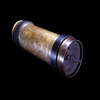

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953 at the Smithsonian's National Postal Museum, highlighting the remarkable pneumatic tube systems that revolutionized mail transport in the late 19th century. These systems, which began in Philadelphia in 1893 and soon after in New York City in 1897, utilized underground tubes to move mail swiftly across cities. Each canister, or carrier, was engineered to accommodate up to 500 letters and traveled through the tubes propelled by compressed air, achieving an average speed of 35 miles per hour in a spinning motion. At its peak, the system managed to transport 6 million pieces of mail daily, with five carriers dispatched every minute. The pneumatic system 

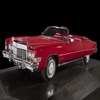

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the iconic 1973 red convertible Eldorado Cadillac that belonged to the legendary rock musician Chuck Berry. It is part of the Smithsonian's National Museum of African American History and Culture collection and was a key element in the 1987 documentary "Hail! Hail! Rock 'n' Roll," which celebrated Berry's life through two concerts for his 60th birthday. A memorable moment in the film occurs when Berry drives this Cadillac onto the stage of the Fox Theater in St. Louis, a venue that had previously denied him access as a child due to racial prejudice. Berry, who often referenced his beloved Cadillacs in his songs, used this vehicle to travel to all his performances, making it a symbol of his

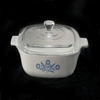

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a notable white casserole dish from CorningWare, dating back to 1965, adorned with the brand's signature blue cornflower design. This dish is a testament to the evolution of kitchenware, as it was created from Pyroceram, a groundbreaking material developed for military use during World War II. After the war, its excellent thermal resistance and ability to resist stains and odors made it ideal for home chefs. This versatile dish could be used for cooking, freezing, and serving, streamlining meal preparation. In the 1990s, CorningWare shifted towards ceramic stoneware to adapt to consumer preferences for more colorful and varied designs, but the original glass-ceramic dis

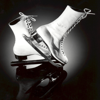

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, a distinguished Norwegian figure skater from the early to mid-20th century. Henie is celebrated for her innovative approach to figure skating during the 1920s and 1930s, which included the introduction of white leather skates, a striking contrast to the traditional black. Her captivating performances earned her ten consecutive world skating titles starting in 1927, where she mesmerized audiences with her unique blend of dance and skating. Henie's influence extended to fashion as she popularized the short skirt and white skates, elements that remain prevalent today. Her Olympic accolades include gold in ladies singles at the Winter Olympics in 1928

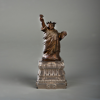

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Produced in large quantities, this statuette was a fundraising effort to support the construction of the statue's pedestal in New York Harbor. Designed by French sculptor Frédéric-Auguste Bartholdi, the models were made in both six-inch and twelve-inch sizes, with the six-inch model priced at one dollar and the twelve-inch model at five dollars. A national newspaper campaign promoted these models, selling the six-inch version for one dollar and the twelve-inch version for five dollars. Richard Butler, a rubber manufacturer from New York, played a crucial role as the chair of the American

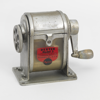

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920 and manufactured by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). As the back-to-school season approaches, this artifact may evoke fond memories of classroom experiences. The Dexter sharpener, which was an evolution of the original introduced in 1914, featured enhancements such as a rotating wheel allowing for multiple pencil sizes. By the 1920s, APSCO had produced a variety of similar sharpeners, showcasing its leadership in the mechanical pencil market. The sharpener'

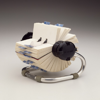

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, a staple of office organization that has stood the test of time. Manufactured by the Rolodex Corporation in the USA, this particular model is constructed from a blend of materials including bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The Rolodex operates on a cylindrical mechanism that allows users to flip through A-Z, facilitating easy access to business contacts. Despite the digital shift, the Rolodex remains a popular organizational tool, symbolizing a nostalgic yet enduring approach to information management. The invention is credited to Arnold Neustadte

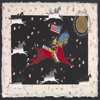

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the "Lakota Horse Mask," a captivating work by Jim Yellowhawk, created in 2008 and representing the Cheyenne River Lakota tribe. This piece, made with acrylic on paper and adorned with gold leaf, highlights the essential relationship between Native American tribes and horses, often referred to as the Horse Nation. Horses have been transformative for Native cultures, serving as vital partners in both peaceful and wartime contexts. Historically, horses first appeared in the Americas over 40 million years ago but became extinct until their reintroduction by Columbus in 1493. This artwork is part of the Smithsonian's National Museum of the American Indian collection and is featured in the onlin

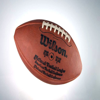

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a hallmark of American sports, which has been the official football of the Super Bowl since Super Bowl II in 1968. The specific football on display was used during Super Bowl XIV on January 20, 1980, at the Rose Bowl in Pasadena, California, where the Pittsburgh Steelers emerged victorious against the Los Angeles Rams with a score of 31-19. This win was historic, marking the Steelers' fourth Super Bowl championship and earning quarterback Terry Bradshaw the Most Valuable Player award for the second consecutive year. The Wilson Duke football is celebrated for its premium leather construction, which includes sewn ends and lock-stitch seams, and has been the official

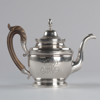

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a beautifully crafted silver teapot by Peter Bentzon, an influential American silversmith active from around 1817 to after 1829. The teapot is characterized by its oval vase shape, set on a spreading pedestal foot, with a gracefully curved spout embellished with an incised patera and a wooden, leaf-capped scroll handle. Its hinged domed cover is adorned with an acorn finial, enhancing its decorative appeal. The teapot bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" along the bottom rim, adding to its historical significance. Measuring 7 inches in height, 12 inches in width, and 5 inches in depth, this piece is part of the National Museum of Africa

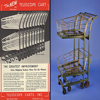

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Telescoping Shopping Cart, created in 1949 by Orla E. Watson, who was the first to design a cart that allowed for efficient stacking. As the holiday shopping rush commences, it's fascinating to consider how this design has influenced modern shopping practices. Watson's design was crafted to ensure that each parked cart occupied only a fraction—one-fifth, to be precise—of the space typically occupied by traditional carts. The first iteration of this cart was introduced at Floyd's Super Market in Kansas City, Missouri, in 1947, and it was soon followed by a launch at the prestigious New York City store, F. Schumacher & Co., in 1948. By 1949, this design was being produced in large quanti

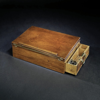

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the portable writing desk of Thomas Jefferson, which he used while drafting the Declaration of Independence in 1776. Designed by Jefferson himself, the desk is equipped with a hinged writing surface and a drawer for writing materials. As a delegate from Virginia, he was selected to draft this crucial document, which was officially adopted on July 4, 1776, and serves as a foundational statement of American independence. The desk not only housed the initial drafts of this declaration but also bore witness to Jefferson's life as a statesman and president. In 1825, he inscribed a personal message under the desk's writing board, acknowledging its potential symbolic importance. Jefferson's desk 

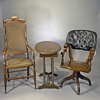

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from the Civil War, specifically the chair that General Ulysses S. Grant used while negotiating the terms of surrender with General Robert E. Lee on April 9, 1865, at Wilmer McLean's home in Appomattox Court House, Virginia. In this chair, Grant engaged with Lee about the fate of his troops and the terms of surrender, which he officially signed at the oval table. Although the Civil War did not end immediately with this surrender, it symbolized a significant turning point. The chair, made of wood and measuring 37.5 inches in height, is a powerful reminder of this historic meeting. It was taken as a memento by various individuals, including General E. W. Whitaker, who t

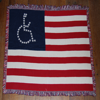

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that incorporates the universal access symbol, a tribute to the advocacy efforts of the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, symbolizes the fight for civil rights among disabled individuals. ADAPT, founded in 1983, emerged from the post-World War II disability rights movement, which saw individuals unite to share their stories and advocate for their rights. The blanket's design, adorned with stitched stars, emphasizes the notion that civil rights are universal. Although this piece is currently not on display, it serves as a significant artifact within the National Museum of American H

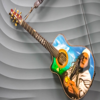

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer renowned for his vallenato music. Vallenato, a vibrant genre from Colombia's Atlantic coast, is characterized by its upbeat tempo and the integration of European instruments, particularly the accordion, along with poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, this music was performed by rural workers and cowboys, but in the 1990s, Vives and other artists began to incorporate pop and rock influences, allowing the genre to resonate with audiences beyond Colombia, including in the United States. The guitar on display, handmade by a Colombian luthier, features an airbrushed portrait 

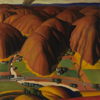

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating painting by Ross Dickinson, an artist whose work emerged from the Public Works of Art Project during the Great Depression. Created in 1934, the painting depicts the California Central Valley, where a gentle river meanders alongside vibrant green fields at the foot of dry, rugged hills. The imagery evokes the idyllic visions of a promised land sought by many during the Dust Bowl, yet it is laced with tension. Dickinson's portrayal of the landscape is layered with meaning, as he explores the interplay between humans and nature, addressing themes of environmental protection and the threats to various species. The artist's use of contrasting colors between the green farms and the

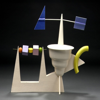

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Peter Shire, an influential artist known for his vibrant ceramics, specifically his Weathervane Teapot. Created in 1981, this piece is characterized by its playful arrangement of shapes, including squares and spheres, alongside swirling rods and hollow tubes. Shire's intention was to disrupt established, class-based perceptions of tea-drinking rituals, making them more accessible and engaging for everyone. The teapot itself is a striking example of his innovative design, combining a traditional oval vase shape with an unconventional assemblage of geometric forms. Shire's artistic journey is marked by a transition from his earlier grid-based ceramics to these contemporary pieces

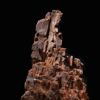

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, a powerful artifact from the Civil War, currently displayed at the Smithsonian's National Museum of American History. The stump, which dates back to 1864–65, was once part of a large oak tree located in a serene meadow near Spotsylvania Court House, Virginia. On May 12, 1864, this tranquil setting was transformed into a battlefield as Confederate forces under Gen. Robert E. Lee faced an assault from Union troops. The ensuing conflict, which would become known as the Bloody Angle, resulted in an estimated 31,000 casualties among the 152,000 soldiers engaged. The stump bears the marks of war, with several Minié balls still embedded in its wood, serving as a stark

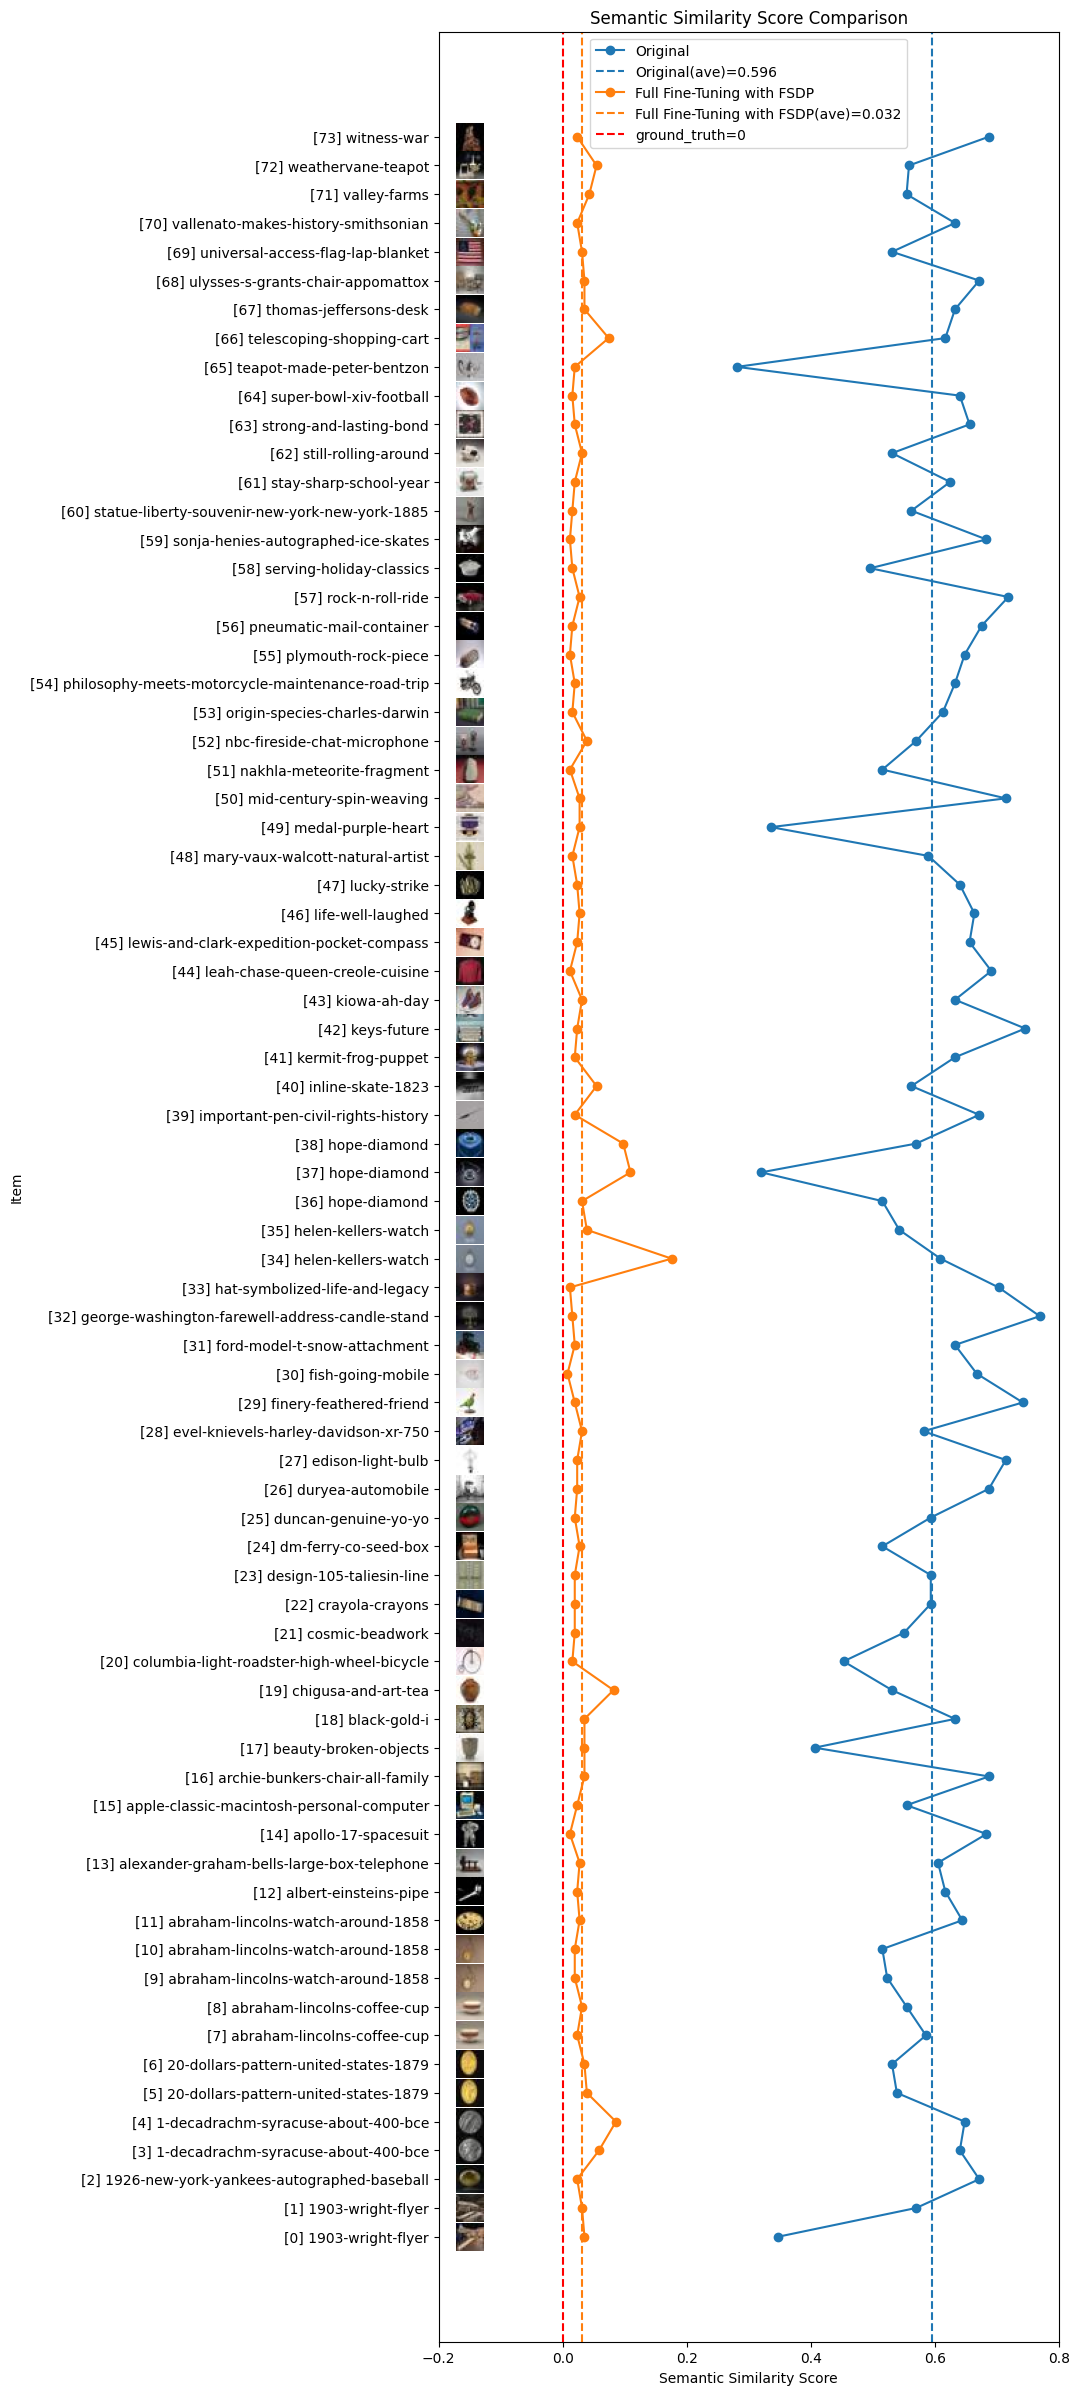

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(full_fine_tuning_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 10)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('Full Fine-Tuning with FSDP', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 3.4 Save the Fine-Tuned Model Locally  

In [3]:
# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_parameters.txt')
full_fine_tuning_model.save_pretrained(save_directory='./results/finetuned_model')


==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': device(type='cpu')}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, Tru